# Loan Approval Prediction Project
Team: Shailja Somani, Verity Pierson, & Mirna Philip\
Dataset Used: Demographic and loan information for select loan applicants, along with if they were approved or not. Retreived from Kaggle at: https://www.kaggle.com/datasets/mirzahasnine/loan-data-set?resource=download\
Project Github: https://github.com/shailja-somani-0/loan-approval-pred

## Import and Clean Dataset

In [1]:
# Import packages necessary
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
import xgboost as xg
from sklearn.model_selection import GridSearchCV

In [2]:
# Check working directory if necessary - commented out as not necessary
#os.getcwd()

'/Users/shailjasomani/Documents/USD_MS_ADS/ADS_502/Final_Proj'

In [3]:
# Importing the csv file 
loan_df = pd.read_csv('loan_train.csv', header=0, sep=',')
loan_df.head()

,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Term,Credit_History,Area,Status
0,Male,No,0,Graduate,No,584900,0.0,15000000,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,458300,150800.0,12800000,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,300000,0.0,6600000,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,258300,235800.0,12000000,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,600000,0.0,14100000,360.0,1.0,Urban,Y


In [4]:
# Checking to see what the data looks like
loan_df.describe()

,Applicant_Income,Coapplicant_Income,Loan_Amount,Term,Credit_History
count,6.140000e+02,6.140000e+02,6.140000e+02,600.00000,564.000000
mean,5.403459e+05,1.621246e+05,1.414104e+07,342.00000,0.842199
std,6.109042e+05,2.926248e+05,8.815682e+06,65.12041,0.364878
min,1.500000e+04,0.000000e+00,0.000000e+00,12.00000,0.000000
25%,2.877500e+05,0.000000e+00,9.800000e+06,360.00000,1.000000
50%,3.812500e+05,1.188500e+05,1.250000e+07,360.00000,1.000000
75%,5.795000e+05,2.297250e+05,1.647500e+07,360.00000,1.000000
max,8.100000e+06,4.166700e+06,7.000000e+07,480.00000,1.000000


In [5]:
# Drop all rows with null values
loan_df = loan_df.dropna()
loan_df.shape

(499, 12)

In [22]:
# One-hot encode Area, which has 3 possible answers
loan_encoded = pd.get_dummies(loan_df, columns=['Area'], drop_first=False)

# Encode binary features & target variable to 1 and 0 - use drop_first to have only one column per variable
loan_encoded = pd.get_dummies(loan_encoded, columns=['Gender', 'Married', 'Education', 'Self_Employed','Status'], drop_first=True)

loan_encoded.head()

,Dependents,Applicant_Income,Coapplicant_Income,Loan_Amount,Term,Credit_History,Area_Rural,Area_Semiurban,Area_Urban,Gender_Male,Married_Yes,Education_Not Graduate,Self_Employed_Yes,Status_Y
0,0,584900,0.0,15000000,360.0,1.0,0,0,1,1,0,0,0,1
1,1,458300,150800.0,12800000,360.0,1.0,1,0,0,1,1,0,0,0
2,0,300000,0.0,6600000,360.0,1.0,0,0,1,1,1,0,1,1
3,0,258300,235800.0,12000000,360.0,1.0,0,0,1,1,1,1,0,1
4,0,600000,0.0,14100000,360.0,1.0,0,0,1,1,0,0,0,1


In [23]:
# Split data into X & y and train and test datasets
X = loan_encoded.drop('Status_Y', axis=1)
y = loan_encoded[['Status_Y']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=38)

# print the shapes of the resulting splits
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (349, 13)
X_test shape: (150, 13)
y_train shape: (349, 1)
y_test shape: (150, 1)


## Do some EDA on the data

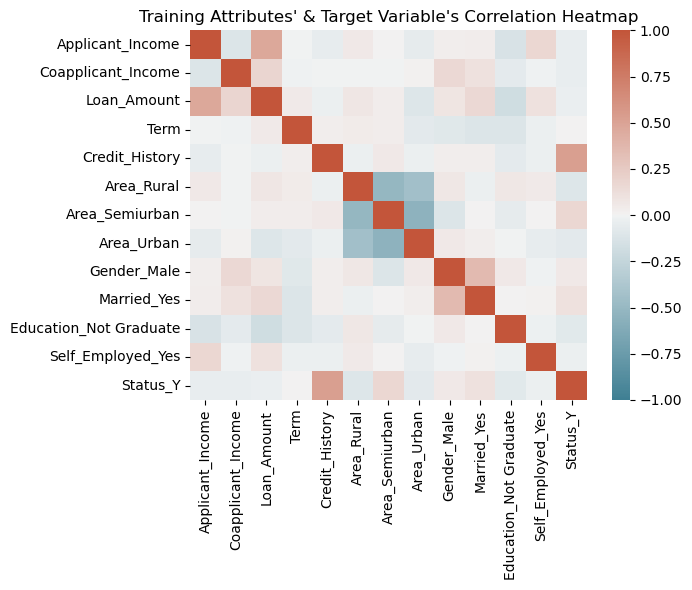

In [24]:
# Create a heatmap to show correlations between all training attributes & target variable (status)
# Get the correlation matrix 
correlation_matrix = loan_encoded.corr()

# create heatmap, set hues for negative, positive areas of map and saturation amount.
# create heatmap given: dataset, value range to anchor map with (-1 and 1), colormap name set above, set title
red_blue = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(correlation_matrix, vmin = -1, vmax = 1, cmap=red_blue).set(title="Training Attributes' & Target Variable's Correlation Heatmap")
plt.show()